# Extremely Fast Decision Tree Implementation

In [1]:
import numpy as np
from river.drift import ADWIN


class Node:
    def __init__(self, is_leaf=True, prediction=None):
        self.is_leaf = is_leaf
        self.prediction = prediction
        self.split_feature = None
        self.split_value = None
        self.children = {}
        self.class_counts = np.zeros(2)
        self.adwin = ADWIN()

def hoeffding_bound(R, n):
    return np.sqrt((R**2 * np.log(1/0.10)) / (2 * n))


def entropy(labels):
    
    # Count the occurrences of each class
    label_counts = np.bincount(labels, minlength=2)
    
    # Calculate the probabilities for each class
    probabilities = label_counts / np.sum(label_counts)
    
    # Remove probabilities equal to 0 for log2 calculation
    probabilities = probabilities[probabilities > 0]
    
    # Calculate the entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))
    
    return entropy 

def information_gain(parent_labels, left_labels, right_labels):
    
    # Entropy before the split
    entropy_before = entropy(parent_labels)
    
    # Weighted entropy after the split
    total_size = len(parent_labels)
    left_size = len(left_labels)
    right_size = len(right_labels)
    
    weighted_entropy = (left_size / total_size) * entropy(left_labels) + \
                        (right_size / total_size) * entropy(right_labels)

    # Information gain is the reduction in entropy
    return entropy_before - weighted_entropy


def best_split(data, labels):
    
    # Initialize Variables
    features = data.shape[1]
    best_split_feature = None
    best_split_value = None
    best_split_information_gain = -np.inf
    #n = len(data)
    
    # Iterate though all the features
    for feature in range(features):
        
        values = np.sort(np.unique(data[:, feature])) # Expand this
        values_n = len(values) -1
        
        # Sort through the unique values
        for i in range(values_n):
            split_value = (values[i] + values[i+1]) / 2
            
            # MArk the values with lower than the split
            smaller_values = data[:, feature] <= split_value
            #Negation fo the left
            bigger_values = ~smaller_values
            
            # # COunt the Smaller and the Bigger calues
            # left_count = np.bincount(labels[smaller_values], minlength=2)
            # right_count = np.bincount(labels[bigger_values], minlength=2)
            
            # Calculate Information Gain
            info_gain = information_gain(labels, labels[smaller_values], labels[bigger_values])
            
            if info_gain > best_split_information_gain:
                best_split_feature = feature
                best_split_value = split_value
                best_split_information_gain = info_gain
                
    return best_split_feature, best_split_value

class EFDT:
    def __init__(self):
        self.root = Node(is_leaf=True, prediction=0)
    
    def fit(self, X, y):
        
        #Adjust to handle 0 and 1
        y_adjusted = y - 1

        for xi, yi in zip(X, y_adjusted):
            self._fit_single(xi, yi)
    
    
    def _fit_single(self, x, y):
        y = y - 1
        node = self.root
        while not node.is_leaf:
            if x[node.split_feature] <= node.split_value:
                node = node.children['left']
            else:
                node = node.children['right']
        
        node.class_counts[y] += 1
        node.prediction = np.argmax(node.class_counts)
        
        # ADWIN update and drift check
        old_prediction = node.prediction
        node.adwin.update(y == old_prediction)  # Using accuracy as feedback; adapt as needed
        
        if node.adwin.drift_detected:
            # Reset node upon drift detection
            node.is_leaf = True
            node.class_counts = np.zeros(2)
            node.children = {'left': None, 'right': None}

        # Attempt to split if the node is still a leaf after drift check
        if node.is_leaf and np.sum(node.class_counts) > 25:  
            self._attempt_to_split(node, x, y)
    
    def _attempt_to_split(self, node, x, y):
        X_sub = np.array([x])  
        y_sub = np.array([y])  
        
        feature, value = best_split(X_sub, y_sub)
        if feature is not None:
            
            n = np.sum(node.class_counts)
            epsilon = hoeffding_bound(1, n)
            
            # Check if the split is significant
            if epsilon < 0.1: 
                node.is_leaf = False
                node.split_feature = feature
                node.split_value = value
                node.children['left'] = Node(is_leaf=True, prediction=np.argmax(node.class_counts))
                node.children['right'] = Node(is_leaf=True, prediction=np.argmax(node.class_counts))
    
    
    def predict(self, x):
        node = self.root
        while not node.is_leaf:
            if x[node.split_feature] <= node.split_value:
                node = node.children['left']
            else:
                node = node.children['right']
                
        # Turn it back to 1 and 2
        pred = node.prediction + 1
        return pred



## Load the Dataset
Here we are loading the data from the txt file and adding drift to the dataset itself. This means that the distribution changed in the dataset, to achieve this changed in distribution the labels were flipped.

In [2]:
import numpy as np

# Assuming your file is named 'data.txt' and located in the current directory
file_path = 'Skin_NonSkin 2.txt'

# Load the data
data = np.loadtxt(file_path, delimiter='\t')
np.random.shuffle(data)


# Split the data into features and target variable
X = data[:, :-1]
y = data[:, -1].astype(int) 

current = 0
drift = False

for i in range(len(y)):
    if drift:
        y[i] = 1 if y[i] == 2 else 2
    current += 1
    
    # Changes every 50000
    if current > 50000:
        drift = not drift
        current = 0



## Evaluate the Results

In [3]:

# Initialize the Tree
model = EFDT()

#Initialize variables
errors_count = 0
error_rates = []

for idx in range(len(y)):
    pred = model.predict(X[idx])

    if pred != y[idx]:
        errors_count += 1
        
    
    # Calculate Error Rate
    
    if idx > 10000:
        error_rate = errors_count / (idx + 1)
        error_rates.append([idx, error_rate])
    
    # Print Every 10000 Iterations
    if idx % 10000 == 0:
        print(f'Instance: {idx}')
    

    model._fit_single(X[idx], y[idx])



Instance: 0
Instance: 10000
Instance: 20000
Instance: 30000
Instance: 40000
Instance: 50000
Instance: 60000
Instance: 70000
Instance: 80000
Instance: 90000
Instance: 100000
Instance: 110000
Instance: 120000
Instance: 130000
Instance: 140000
Instance: 150000
Instance: 160000
Instance: 170000
Instance: 180000
Instance: 190000
Instance: 200000
Instance: 210000
Instance: 220000
Instance: 230000
Instance: 240000


# Display the Results

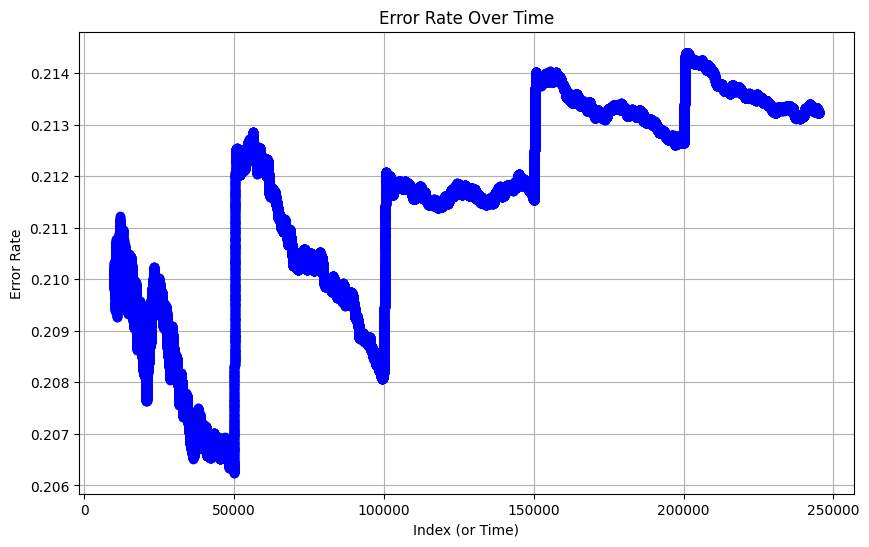

In [4]:
import matplotlib.pyplot as plt

# Splitting the list into two lists, idxs and errors
idxs, errors = zip(*error_rates)

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Specifies the figure size
plt.plot(idxs, errors, marker='o', linestyle='-', color='b')  # Marker, linestyle, and color are optional
plt.title('Error Rate Over Time')
plt.xlabel('Index (or Time)')
plt.ylabel('Error Rate')
plt.grid(True)  # Optional: Adds a grid for easier reading
plt.show()